## Finding specific variants in each cluster
Using the clones, we want to find variants in each clone that are specific to them.
To define specificity, we will use two parameters: VAF frequency cutoff, and different %of population to have that variant.
These parameters will be used to compare each clone's variants to the population

In [6]:
import multiprocessing

import pandas as pd
import numpy as np
import random
from deap import base, algorithms
from deap import creator
from deap import tools

In [51]:
try:
    indir = snakemake.params.indir
    outdir = snakemake.params.outdir
    donor =  snakemake.params.donor
    anno_cells_meta_f = snakemake.input.anno_cells_meta_f  #"/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
    # Objective weights. order of the columns
    weights =  snakemake.params.weights
    objectives_l = snakemake.params.get(objectives_l, 
                                        ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                                         "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                                         "pct_thresh","other_pct_thresh", 
                                         "n_vars", "obj_nclones_more_than_one_unique"])
    ncpus = snakemake.params.get(ncpus, 8)
    topn = snakemake.params.get(topn, 16)
except:                                       
    indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
    outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/distinct_variants/donor0/scrap/"
    donor = 0
    anno_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
    # pct_thresh = [0.01, 0.1, 0.25, 0.4, 0.5, 0.75, 0.95]
    # other_pct_thresh = [0.01, 0.1, 0.25, 0.5]
    # af_thresh = [0, 0.01, 0.1, 0.25, 0.4]

    # Objective weights. order of the columns
    weights = [1,0,0,1,-1, 1, 1] #[1,1,1,1,1] #np.ones([len(objectives),])
    objectives_l = ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                    "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                    "pct_thresh","other_pct_thresh", "n_vars", "obj_nclones_more_than_one_unique"] #"nvars"
    ncpus=8
    topn=16


In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from mplh import cluster_help as ch
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})

from icecream import ic

fig_utils from mplh
0.5.6


In [3]:
objectives = {ind:x for ind,x in enumerate(objectives_l)}
weights = np.array(weights)

assert(len(weights)==len(objectives))

In [4]:
objectives

{0: 'variants_with_clone_norm_by_1_over_nclones_with_variant',
 1: 'max_clone_ncells_over_nclones',
 2: 'max_clone_ncells_over_ncells',
 3: 'pct_thresh',
 4: 'other_pct_thresh',
 5: 'n_vars',
 6: 'obj_nclones_more_than_one_unique'}

In [5]:
param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]
n_params = 3

In [8]:
if not exists(outdir):
    os.mkdir(outdir)

## Load & preprocess:
- AF df
- DP df
- cells_meta with clone labels. need to create name as donor_lineage

Remove donor variants (>0.9 in 90% of pop)

In [9]:
af_indir = join(indir, "sc_af", f"donor{donor}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

print(AF_df.shape)
print(DP_df.shape)
print("Depth")
print(DP_df.head())
AF_df.head()

cells_meta = pd.read_csv(join(indir, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==donor]
curr_labels

conditions = curr_labels["condition"].unique()
conditions

def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds

donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]
donor_inds

(68, 9023)
(68, 9023)
Depth
         AAACGAAAGAATCAAC-1_Control  AAACGAAAGCGAGAAA-1_Control  \
Variant                                                           
10397G                          2.0                        16.0   
10463C                         11.0                        16.0   
10559G                         15.0                        26.0   
10589A                         17.0                        21.0   
11251G                         13.0                        25.0   

         AAACGAAAGTACAGAT-1_Control  AAACGAAAGTTAGCAA-1_Control  \
Variant                                                           
10397G                          1.0                         5.0   
10463C                          3.0                         9.0   
10559G                          5.0                         5.0   
10589A                          6.0                         7.0   
11251G                          5.0                         7.0   

         AAACGAACACTCGCAG-1_Cont

Index(['10397G', '10589A', '11761T', '13188T', '1438G', '146C', '14766T',
       '15326G', '16126C', '16355T', '16362C', '196C', '204C', '2442C', '263G',
       '2706G', '3847C', '4769G', '58C', '64T', '7028T', '73G', '750G',
       '7598A', '827G', '8292A', '8461T', '8860G'],
      dtype='object', name='Variant')

## Plot all cells in each clone

## objective: 
1. Maximize: /sum_{v \in V}{max({c_{ncells}\in C}/|C|), where V is number of variants, c_{i,v,ncells} is number of cells in clone i with variant v, and C is the set of clones with the variant. We want to maximize this objective. Across all variants.
2. Same as 1, but denominator is not number of clones with variant but number of cells with variant
3. Maximize pct_thresh
4. Minimize other_pct_thresh (not high priority)

## Constraint:
1. pct_thresh>=other_pct_thresh
2. af_thresh*coverage_thresh>=2

## Bounds:
1. pct_thresh: 0.1-1
2. other_pct_thresh: 0.1-1
3. af_thresh: 0.01-0.4
4. coverage_thresh: 2-60


In [10]:
from icecream import ic

ic.disable()

In [11]:
def get_unique_variants(cln_af, other_af, pct_thresh, af_thresh, other_pct_thresh):
    """ gets the distinct variants in a clone.
    """
    n_thresh = pct_thresh*cln_af.shape[1]
    n_oth_thresh = other_pct_thresh*other_af.shape[1]
    bin_cln = cln_af>af_thresh
    bin_other = other_af>af_thresh
    cells_above = bin_cln.sum(axis=1)
    pct_cells_above = cells_above/bin_cln.shape[1]
    up_vars = bin_cln.loc[cells_above > n_thresh].index
    cells_other_above = bin_other.sum(axis=1)
    pct_cells_other_above = cells_other_above/bin_other.shape[1]
    up_oth_vars = bin_other.loc[cells_other_above > n_oth_thresh].index
    uniq_vars = list(set(up_vars) - set(up_oth_vars))
    out = pd.DataFrame(index=uniq_vars, data={"n_cells":cells_above.loc[uniq_vars].values, 
                                              "n_other_cells": cells_other_above.loc[uniq_vars].values,
                                              "pct_above": pct_cells_above,
                                              "pct_other_above": pct_cells_other_above})
    out["pct_thresh"] = pct_thresh
    out["af_thresh"] = af_thresh
    out["other_pct_thresh"] = other_pct_thresh
    return out


def get_clones_unique_variants(solution, data):
    all_unique_df = []
    pct_thresh, af_thresh, other_pct_thresh = solution["pct_thresh"], solution["af_thresh"], solution["other_pct_thresh"] #solution[0], solution[1], solution[2]
    curr_labels = data["curr_labels"]
    AF_df = data["AF_df"]
    DP_df = data["DP_df"]
    for cln, val in curr_labels.groupby("name"):
        ic(cln)
        cln_af = AF_df.loc[:, val.index]
        other_af = AF_df.loc[:, curr_labels.drop(val.index).index]
        curr_dp = DP_df.loc[:, val.index]
        curr_labs = curr_labels[curr_labels.index.isin(cln_af.columns)]
        ic(cln_af.shape)
        unique_df = get_unique_variants(cln_af, other_af, pct_thresh, af_thresh, other_pct_thresh)
        unique_df["clone"] = cln
        unique_df["id"] = unique_df["clone"] + "_" + unique_df["pct_thresh"].astype(str)+ "_" + unique_df["af_thresh"].astype(str)+ "_" + unique_df["other_pct_thresh"].astype(str)
        unique_df["variant"] = unique_df.index
        unique_df = unique_df.set_index("id")
        all_unique_df.append(unique_df)
    all_unique_df = pd.concat(all_unique_df)
    all_unique_df["log2_n_cells"] = np.log2(all_unique_df["n_cells"]+1)
    return all_unique_df



def _objective_two_unique_vars_in_clone(all_unique_df, to_pivot=True):
    if to_pivot:
        if "id" in all_unique_df.columns:
            df = all_unique_df.pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
        else:
            df = all_unique_df.reset_index().pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
    else:
        df = all_unique_df
    vars_to_keep = df.loc[:,(df>0).sum()==1].columns # Variants with just 1 clone
    clones_to_keep = df.loc[df.sum(axis=1)>1].index # Clones w >2 enriched variants
    obj = 0
    def cl_more_than_one(cl_ser):  
        curr = cl_ser[cl_ser > 0] # variants in a clone
        # check if more than one unique variant for this clone
        return sum([True if x in vars_to_keep else False for x in curr.index]) > 1

#     def cl_more_than_one(cl_ser, vars_to_keep):  
#         curr = cl_ser[cl_ser > 0] # variants in a clone
#         # check if more than one unique variant for this clone
#         return sum([True if x in vars_to_keep else False for x in curr.index]) > 1
    #obj = sum(df.loc[clones_to_keep].apply(lambda x: x(lambda y):, axis=0))
    obj = sum(df.loc[clones_to_keep].apply(cl_more_than_one, axis=1))
    return obj


def _objectives(data):
    all_unique_df = data["all_unique_df"]
    #print('all_unique_df', all_unique_df.head)
    ic('all_unique_df', all_unique_df.shape)
    obj_max_nce_over_ncl = 0
    obj_max_nce_over_nce = 0
    obj_cl_over_ncl = 0
    obj_nvars = 0
    if len(all_unique_df) == 0:
        #print('all 0', all_unique_df.columns)
        return {x:(-1*np.inf) for x in objectives_l} # return score of 0 since all positive values
    obj_d = all_unique_df.iloc[0]["pct_thresh"] 
    obj_e = all_unique_df.iloc[0]["other_pct_thresh"]
    for v, v_df in all_unique_df.groupby("variant"):
        ic(v)
        max_ncells = max(v_df["n_cells"])
        n_clones = len(set(v_df["clone"].values))
        obj_max_nce_over_ncl += max_ncells/n_clones
        obj_max_nce_over_nce += max_ncells/v_df["n_cells"].sum()
        
        if n_clones != 0:
            obj_cl_over_ncl += 1/n_clones
            obj_nvars += 1
        
    # calculate objective number of clones with more than one unique variant
    obj_nclones_more_than_one_unique =  _objective_two_unique_vars_in_clone(all_unique_df, to_pivot=True)
    
    objectives = {"variants_with_clone_norm_by_1_over_nclones_with_variant":obj_cl_over_ncl,
                  "max_clone_ncells_over_nclones":obj_max_nce_over_ncl, 
                  "max_clone_ncells_over_ncells":obj_max_nce_over_nce, 
                  "pct_thresh":obj_d,"other_pct_thresh":obj_e,
                   "n_vars":obj_nvars, "obj_nclones_more_than_one_unique": obj_nclones_more_than_one_unique}
    return objectives

def _constraints(solution):
    #if solution["pct_thresh"] < solution["other_pct_thresh"]:
    if "coverage_thresh" not in solution:
        return None
    if solution["af_thresh"]*solution["coverage_thresh"] >= 2:
        return True
    else:
        return False


def evaluate_series(individual_ser, AF_df, DP_df, curr_labels, return_data=False):
    params = individual_ser.to_dict()
    #print('params', params)
    #solution = {"pct_thresh": individual[0], "af_thresh":individual[1],  "other_pct_thresh": individual[2]}
    data = {"AF_df": AF_df, "DP_df":DP_df, "curr_labels":curr_labels} 
    all_unique_df = get_clones_unique_variants(params, data)
    data["all_unique_df"] = all_unique_df
    eval_out = _objectives(data)
    if return_data:
        return pd.Series(eval_out), data
    else:
        return pd.Series(eval_out)



## GA or gridsearch on parameters and evaluate objectives 


## Grid search

In [12]:
# parallel setup
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=ncpus, progress_bar=True)
from itertools import product


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [13]:
pct_thresh = np.arange(0.05, 1, 0.05)
other_pct_thresh = np.arange(0.005, 1, 0.05)
af_thresh = np.arange(0.005, 1, 0.05)


# There are 7 params to use for calling the clone
params = {"pct_thresh": pct_thresh,
          "other_pct_thresh": other_pct_thresh,
          "af_thresh": af_thresh,}
full_params = list(product(*list(params.values())))
full_params = pd.DataFrame(full_params, columns=params.keys())

print(full_params.shape)
full_params.head()


(7600, 3)


,pct_thresh,other_pct_thresh,af_thresh
0,0.05,0.005,0.005
1,0.05,0.005,0.055
2,0.05,0.005,0.105
3,0.05,0.005,0.155
4,0.05,0.005,0.205


In [ ]:
if full_params.shape[0]>=10000:
    results_df = full_params.sample(10000).parallel_apply(evaluate_series, args=(AF_df, DP_df, curr_labels), axis=1)
else:
    results_df = full_params.parallel_apply(evaluate_series, args=(AF_df, DP_df, curr_labels), axis=1)


## Drop the 0 scores before weighing

In [ ]:
(results_df>0).any()

In [ ]:
drop_inds = results_df.loc[(results_df==0).all(axis=1)].index


In [ ]:
weights

In [ ]:
drop_inds

In [ ]:
results_df.isna().sum()

In [ ]:
def set_multi_rank(results, weights):
    if "multi" in results.columns: #in case multi was added before
        rank_results = results.drop("multi",axis=1).rank(na_option='top')
    else:
        rank_results = results.rank(na_option='top')
    rank_results["multi"] = (weights*rank_results).sum(axis=1)
    return rank_results.sort_values(by="multi")[::-1]

def set_multi(results, weights):
    print(results.shape)
    # first normalize results for each column to sum to 1
    objs_total = results.replace([-np.inf, np.inf], np.nan).sum(axis=0)
    print('objs_total', objs_total.head())
    results_norm = results.apply(lambda x: x/objs_total.loc[x.name], axis=0)
    
    results_norm["multi"] = (weights*results_norm).sum(axis=1)
    return results_norm.sort_values(by="multi")[::-1]

In [ ]:
results_df.replace([-np.inf, np.inf], np.nan).sum(axis=0)

In [ ]:
results_norm = set_multi(results_df, weights)

rank_df = set_multi_rank(results_norm, weights)
rank_df

In [ ]:
results_df.replace([-np.inf], np.nan).sum()

In [ ]:
results_norm

## drop the na ones

In [ ]:
drop_results = results_norm.loc[results_norm["multi"].isnull()]
results_norm = results_norm.loc[~(results_norm["multi"].isnull())]
results_norm
#results_norm.loc[results_norm["multi"] == np.nan]

## Plot results distributions

In [ ]:
sns.displot(results_norm["multi"])
plt.title("multiobjective function (want to maximize)")
plt.savefig(join(outdir, "loss_multi.png"))

In [ ]:
sns.displot(rank_df["multi"])
#plt.title("multiobjective function rankings (ties are averaged, want to maximize)")
#plt.savefig(join(outdir, "multi_loss.png"))

In [ ]:
sns.displot(rank_df["variants_with_clone_norm_by_1_over_nclones_with_variant"])
plt.title("objective: variants_with_clone_norm_by_1_over_nclones_with_variant (want to maximize)")
plt.savefig(join(outdir, "loss_variants_with_clone_norm_by_1_over_nclones_with_variant.png"))

In [ ]:
sns.displot(rank_df["obj_nclones_more_than_one_unique"])
plt.title("objective: Number of clones with at least 2 unique variants (want to maximize)")
plt.savefig(join(outdir, "loss_variants_with_clone_norm_by_1_over_nclones_with_variant.png"))

In [ ]:
def get_top_n_results(results_df, rank_df, n=12):
    filt_rank = rank_df.sort_values(by=["multi"])[::-1].iloc[:n]
    filt_results = results_df.loc[filt_rank.index]
    return filt_rank, filt_results


In [ ]:
filt_rank, filt_results = get_top_n_results(results_norm, rank_df, n=topn)

filt_results.columns = [f"{x}_obj" for x in filt_results.columns]

filt_results = pd.merge(filt_results, full_params, left_index=True, right_index=True, how="left")
filt_rank = filt_rank.loc[filt_results.index]
filt_results

In [31]:
all_df = []
all_objs = {}
for ind, val in filt_results.iterrows():
    print(ind)
    obj_out, data = evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

6061
7380
5681


In [32]:
# all_df = all_unique

## Either re-run results for top to get unique_df for each param, or store in a dict (harder b/c of the parallel apply). After, need to make all_df by concatenating the results.
Plot A: heatmap FacetGrid, but each axis is a combination of the parameters (can I do col=["colA", "colC"]?


In [33]:
heatmap_input = all_df[["n_cells", "variant"]].reset_index().pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
meta_df = all_df[["af_thresh", "other_pct_thresh", "pct_thresh", "clone"]]
meta_df = meta_df.loc[~(meta_df.index.duplicated())]
meta_df = meta_df.sort_values(["af_thresh","pct_thresh", "other_pct_thresh", "clone"])
heatmap_input = heatmap_input.loc[meta_df.index]

# Get the variants based on total number of cells across parameters
heatmap_input = heatmap_input.loc[:,heatmap_input.sum().sort_values()[::-1].index]
variants_order = heatmap_input.columns

# Get the clones based on total number of cells across parameters
def clone_sum(val):
    #print(val)
    return(heatmap_input.loc[val.index].sum())

clone_sums = meta_df.groupby("clone").apply(clone_sum)
clone_sums = clone_sums.loc[:, clone_sums.sum().sort_values()[::-1].index]
clones_order = clone_sums.index
clones_order



Index(['0_0', '0_1', '0_15', '0_19', '0_2', '0_20', '0_21', '0_22', '0_23',
       '0_24', '0_25', '0_27', '0_28', '0_29', '0_30', '0_31', '0_32', '0_33',
       '0_5'],
      dtype='object', name='clone')

## Create column with all parameter names  

In [34]:
def params_to_str(ser, param_names):
    name = ""
    for p in param_names:
        name = name + f"{p}={ser[p]:.3f}\t"
    return name

def params_and_multi_str(ser):
    param_str = ser["params"]
    name = f"params:\n{param_str.strip()}\nObjective score={ser['multi_obj']} (want to maximize)" 
    return name

In [35]:
all_df["params"] = all_df.apply(params_to_str, axis=1, args=(param_names,))
all_df.head()

filt_results["params"] = filt_results.apply(params_to_str, axis=1, args=(param_names,))
filt_results


filt_results["params_multi"] = filt_results.apply(params_and_multi_str, axis=1)
filt_results
tmp = filt_results.set_index("params")
all_df["multi_obj"] = all_df.apply(lambda x: tmp.loc[x["params"], "multi_obj"], axis=1)
del tmp                               

all_df["params_multi"] = all_df.apply(params_and_multi_str, axis=1)
all_df

,n_cells,n_other_cells,pct_above,pct_other_above,pct_thresh,af_thresh,other_pct_thresh,clone,variant,log2_n_cells,params,multi_obj,params_multi
id,,,,,,,,,,,,,
0_15_0.9500000000000001_0.005_0.10500000000000001,232,710,1.000000,0.080764,0.95,0.005,0.105,0_15,3109C,7.864186,pct_thresh=0.950\naf_thresh=0.005\nother_pct_t...,0.002432,params:\npct_thresh=0.950\naf_thresh=0.005\not...
0_19_0.9500000000000001_0.005_0.10500000000000001,197,462,1.000000,0.052345,0.95,0.005,0.105,0_19,1949A,7.629357,pct_thresh=0.950\naf_thresh=0.005\nother_pct_t...,0.002432,params:\npct_thresh=0.950\naf_thresh=0.005\not...
0_20_0.9500000000000001_0.005_0.10500000000000001,177,498,1.000000,0.056297,0.95,0.005,0.105,0_20,11251G,7.475733,pct_thresh=0.950\naf_thresh=0.005\nother_pct_t...,0.002432,params:\npct_thresh=0.950\naf_thresh=0.005\not...
0_21_0.9500000000000001_0.005_0.10500000000000001,163,573,1.000000,0.064673,0.95,0.005,0.105,0_21,1888A,7.357552,pct_thresh=0.950\naf_thresh=0.005\nother_pct_t...,0.002432,params:\npct_thresh=0.950\naf_thresh=0.005\not...
0_22_0.9500000000000001_0.005_0.10500000000000001,154,104,1.000000,0.011726,0.95,0.005,0.105,0_22,11453A,7.276124,pct_thresh=0.950\naf_thresh=0.005\nother_pct_t...,0.002432,params:\npct_thresh=0.950\naf_thresh=0.005\not...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_25_0.7500000000000001_0.055_0.20500000000000002,99,285,0.761538,0.032048,0.75,0.055,0.205,0_25,14233G,6.643856,pct_thresh=0.750\naf_thresh=0.055\nother_pct_t...,0.002145,params:\npct_thresh=0.750\naf_thresh=0.055\not...
0_29_0.7500000000000001_0.055_0.20500000000000002,92,265,0.807018,0.029745,0.75,0.055,0.205,0_29,13368A,6.539159,pct_thresh=0.750\naf_thresh=0.055\nother_pct_t...,0.002145,params:\npct_thresh=0.750\naf_thresh=0.055\not...
0_30_0.7500000000000001_0.055_0.20500000000000002,82,342,0.788462,0.038345,0.75,0.055,0.205,0_30,4117C,6.375039,pct_thresh=0.750\naf_thresh=0.055\nother_pct_t...,0.002145,params:\npct_thresh=0.750\naf_thresh=0.055\not...


In [36]:
# tmp = heatmap_input.loc[heatmap_input.index.str.contains("0.8_0.005_0.055")]
# tmp.loc["0_19_0.8_0.005_0.055", "14905A"] = 1
# tmp.loc["0_33_0.8_0.005_0.055", "14233G"] = 1
# #print('tmp', tmp.head())

# tmp_obj = _objective_two_unique_vars_in_clone(tmp, to_pivot=False)
# tmp_obj

#     for cl in clones_to_keep:
#         curr_v = df.loc[[cl], (df.loc[cl]>0)]
#         # if clones with >2 variants, count how many of those are unique
#         n_unique_vars = sum(curr_v.apply(lambda x: x.name in vars_to_keep, axis=0))
#         if n_unique_vars>1:
#             obj += 1

## Heatmap of clone-variant number of cells for all the distinguishing variants of the top results

In [37]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    #param_names = kwargs.pop('param_names', None)
    print(data.shape)
    d = data.pivot(index=args[1], columns=args[0], values=args[2]).fillna(0)
    
    # get all clones and variants
    d_full = pd.DataFrame(index=clones_order, columns=variants_order)
    d_full.loc[:,:] = 0
    d_full.loc[d.index,d.columns] = d
    d_full = d_full.astype(float)
    
    # get cluster results with jaccard
    g = sns.clustermap(d_full, method="single")
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]
    plt.close(g.fig)  

    sns.heatmap(d_full.iloc[inds,cols], cbar_kws = dict(orientation="vertical"), **kwargs)
    plt.title(data["params_multi"].values[0])
    return

In [38]:
all_df["params_multi"].iloc[0]

'params:\npct_thresh=0.950\naf_thresh=0.005\nother_pct_thresh=0.105\nObjective score=0.0024315666210959126 (want to maximize)'

In [ ]:
fg = sns.FacetGrid(data=all_df.reset_index(), height=4, sharey=False, sharex=False,
                   col="params", col_wrap=4, col_order=filt_results["params"].values, margin_titles=True)

fg.map_dataframe(draw_heatmap, 'variant','clone', 'log2_n_cells')#, cbar=False)
#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=0.9, hspace = 0.8)

plt.title("multiobjective function (want to maximize)")
plt.savefig(join(outdir, "top_param_results.png"))

(17, 14)
(17, 14)
(8, 14)
(17, 14)
(17, 14)
(17, 14)
(11, 14)
(7, 14)
(17, 14)
(11, 14)
(7, 14)
(17, 14)
(11, 14)
(7, 14)
(20, 14)
(11, 14)


## Create table for the best params

In [ ]:
best_params = filt_results.iloc[0]
best_params = pd.DataFrame(best_params).transpose()
best_params.index = ["objective_scores"]
best_params.loc["weight"] = None
for obj, w in zip(objectives_l, weights):
    best_params.loc["weight", f"{obj}_obj"] = w

best_params

In [ ]:
out_df = all_df[all_df['params'] == best_params.loc["objective_scores", "params"]]
out_df

In [ ]:
clone_var_table = (out_df.pivot(index= 'variant',columns='clone', values='log2_n_cells').fillna(0))
clone_var_table

clones_keep = clone_var_table.loc[:, ~((clone_var_table==0).all(axis=0))].columns
vars_keep = clone_var_table.loc[~((clone_var_table==0).all(axis=1))].index


## Plot best score

In [ ]:
sns.clustermap(clone_var_table)
plt.title(best_params.loc["objective_scores", "params_multi"])
plt.savefig(join(outdir, "best_params.png"))

In [ ]:
sns.clustermap(clone_var_table.loc[vars_keep,clones_keep])
plt.title(best_params.loc["objective_scores", "params_multi"])
plt.savefig(join(outdir, "best_params_filt.png"))

## Save clone-variant table and the parameters

In [ ]:
clone_var_table.to_csv(join(outdir, "best_params_clone_vars.csv"))
clone_var_table.loc[vars_keep,clones_keep].to_csv(join(outdir, "best_params_filt_clone_vars.csv"))
best_params.to_csv(join(outdir, "best_params.csv"))



In [50]:
filt_results.to_csv(join(outdir, "param_results.csv"))

## Filter cells meta and af and df and save 

In [89]:
filt_curr_labels = curr_labels[curr_labels["name"].isin(clones_keep)]
anno_cells = pd.read_csv(anno_cells_meta_f, sep="\t", index_col=0)
#anno_cells = anno_cells.loc[anno_cells["ID"].isin(filt_curr_labels.index)]
#out_cells_meta = anno_cells.loc[anno_cells["ID"].isin(filt_curr_labels.index)]

# overlap cells of anno and curr labels
cells_to_keep = set(anno_cells["ID"].values).intersection(set(filt_curr_labels.index))
out_cells_meta = anno_cells.loc[anno_cells["ID"].isin(cells_to_keep)]
out_cells_meta =  out_cells_meta.reset_index().set_index("ID")

# out_AF_df = AF_df.loc[vars_keep, out_cells_meta.index]
# out_DP_df = DP_df.loc[vars_keep, out_cells_meta.index]
out_AF_df = AF_df.loc[vars_keep, out_cells_meta.index]# ["ID"]]
out_DP_df = DP_df.loc[vars_keep, out_cells_meta.index]#["ID"]]

In [91]:
print(out_cells_meta.shape)
print(out_AF_df.shape)
print(out_DP_df.shape)

assert((out_AF_df.index==out_DP_df.index).all())
assert((out_AF_df.columns==out_DP_df.columns).all())
assert((out_AF_df.columns==out_cells_meta.index).all())

(2346, 40)
(14, 2346)
(14, 2346)


## save cells-meta, af and dp

In [92]:
out_cells_meta.to_csv(join(outdir, "cells_meta.tsv"),sep="\t")
out_AF_df.to_csv(join(outdir, "af.tsv"), sep="\t")
out_DP_df.to_csv(join(outdir, "dp.tsv"), sep="\t")

In [95]:
out_AF_df

ID,AAACGAAAGCGAGAAA-1_Control,AAACGAATCAGGCGCT-1_Control,AAACTCGCATGCACTA-1_Control,AAACTGCCAAGAGATT-1_Control,AAAGATGAGTAGAAGG-1_Control,AAAGATGCAAAGAGAG-1_Control,AAAGGATAGATAGGTT-1_Control,AAAGGATGTGGAGTGT-1_Control,AAAGGGCGTGATGCGA-1_Control,AAAGGGCTCAGTGGTT-1_Control,...,TTTGAGGTCTTTGCAT-1_Input,TTTGGCCAGATCGATA-1_Input,TTTGGCCTCTAGCAAC-1_Input,TTTGGTTGTTCTCGAA-1_Input,TTTGGTTTCCAGCACG-1_Input,TTTGGTTTCGGGAAAC-1_Input,TTTGGTTTCTGAGTCA-1_Input,TTTGTGTGTAGGGTCA-1_Input,TTTGTGTTCGGGAAAC-1_Input,TTTGTGTTCTGGCACG-1_Input
variant,,,,,,,,,,,,,,,,,,,,,
11251G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.023256
11453A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.577778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13368A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.068966,0.000000,0.0,0.000000,...,0.000000,0.038462,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.027778
14233G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.222222,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000
14905A,0.000000,0.000000,0.064516,0.000000,0.000000,0.000,0.000000,0.000000,0.1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
152C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15452A,0.071429,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16294T,0.000000,0.093750,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000
16296T,0.000000,0.093750,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.070175,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000


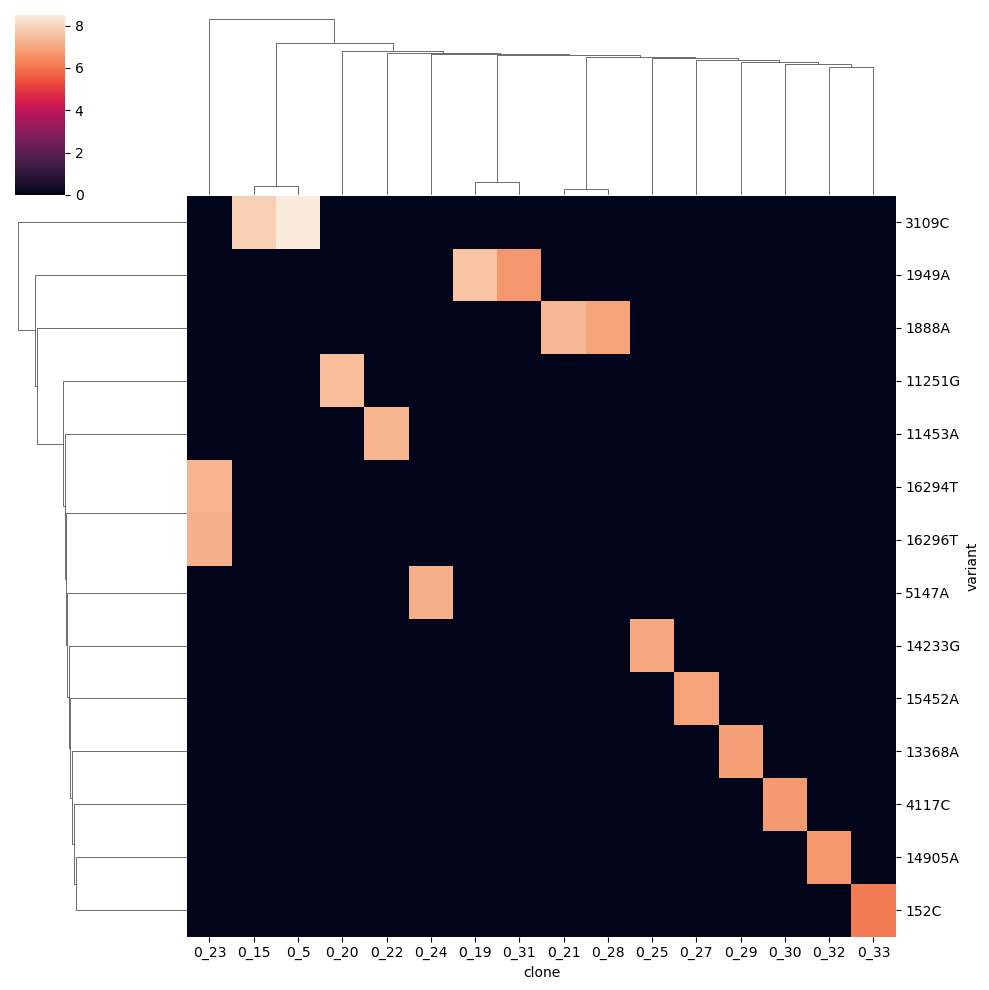

In [93]:
#sns.clustermap(clone_var_table.loc[vars_keep,clones_keep])


---